# Data Mining the Water Table

In [1]:
#!pip install squarify

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import squarify

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.cluster import hierarchy as hc


In [4]:
x_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/x_train.csv', parse_dates = ['date_recorded'])
y_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/y_train.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/x_test.csv', parse_dates = ['date_recorded'])

In [5]:
print(x_train.shape, y_train.shape, x_test.shape)

(59400, 40) (59400, 2) (14850, 40)


In [6]:
x_train.head().T

,0,1,2,3,4
id,69572,8776,34310,67743,19728
amount_tsh,6000,0,25,0,0
date_recorded,2011-03-14 00:00:00,2013-03-06 00:00:00,2013-02-25 00:00:00,2013-01-28 00:00:00,2011-07-13 00:00:00
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A
gps_height,1390,1399,686,263,0
installer,Roman,GRUMETI,World vision,UNICEF,Artisan
longitude,34.9381,34.6988,37.4607,38.4862,31.1308
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni
num_private,0,0,0,0,0


In [7]:
y_train.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2]) # replace labels by numerical values
data_viz = pd.concat([x_train,y_train['status_group']],axis=1) # data and target in one DF
labels = pd.get_dummies(y_train) #one-hot encoding of target
data = x_train.append(x_test) # merge train and test data for processing together
data.shape

(74250, 40)

# Data Cleaning

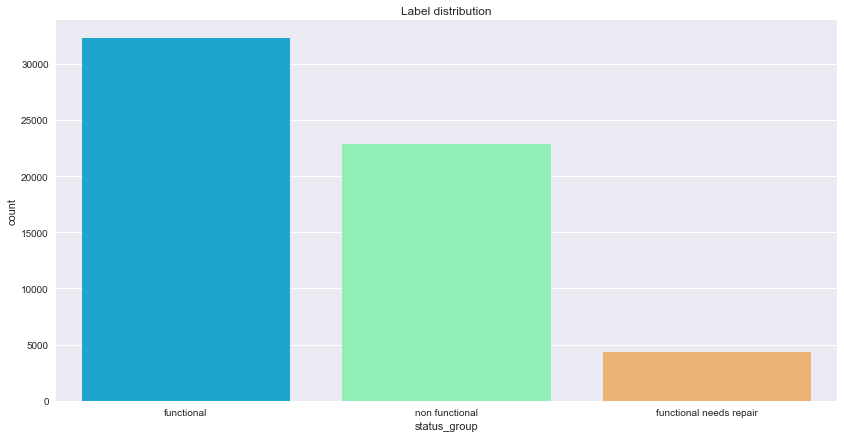

In [9]:
# Few points are labeled need repair, probably will be hardest to predict
plt.figure(figsize=(14,7))
sns.countplot(x='status_group',data=y_train, palette="rainbow")
plt.title("Label distribution")
plt.show()

In [10]:
# feature with null values: funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit
data.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [66]:
#funder
data.groupby(['funder']).size().sort_values(ascending=False)
data.funder.fillna('other', inplace = True)
data.loc[data.funder.str.len() <= 2, 'funder'] = 'other'


In [55]:
# Subvillage
data.groupby(['subvillage'])['id'].count().sort_values()

subvillage
##                  1
Kinapa              1
Kinanundu           1
Kinantugu           1
Kinankumbi          1
Kinankoli           1
Kinaniuba           1
Mwamhuge            1
Kinangolo           1
Kinangari           1
Mwami               1
Kinandili           1
Kinamweri           1
Kinampanda          1
Mwamhuba            1
Kinamo              1
Kinambuga           1
Mwamigagani         1
Kinamalagira        1
Mwamile             1
Kinaki              1
Kinagana            1
Kinaga              1
Mwamili             1
Mwamilyango         1
Mwamishimo          1
Mwamisiange         1
Mwamiswa            1
Kimwagamchuzi       1
Kinamimwa           1
                 ... 
Kichangani        118
Mbugani           119
Azimio            121
Mabatini          125
Mkwajuni          127
Mwenge            129
Bondeni           140
Senta             144
Mjimwema          152
Marurani          152
Mapinduzi         154
Kanisani          158
Mjini             162
Msikitini         167

In [56]:
data.subvillage.fillna(value='other', inplace=True) # make NULL into other
data.loc[data.subvillage.str.len() <= 2, 'subvillage'] = 'other' #make type errors into other
data.subvillage = data.subvillage.apply(lambda x: x.split()[0]) # group some subvillages
data.groupby(['subvillage'])['id'].count().sort_values()

subvillage
Laghandesh         1
Maduara            1
Madukamawili       1
Madukan            1
Rulongo            1
Madumbi            1
Madume             1
Madundani          1
Madundwe           1
Maebdeleo          1
Maekani            1
Rukuvi             1
Maendelo           1
Mafanikio          1
Mafere             1
Mafighwa           1
Madu               1
Madisi             1
Rungo              1
Rungwe             1
Rurama             1
Rupya              1
Ruota              1
Madaho             1
Madale             1
Madali             1
Madanga            1
Mafisa             1
Madanganya         1
Madega             1
                ... 
Kichangani       118
Mbugani          119
Azimio           121
Mabatini         125
Mkwajuni         127
Mwenge           129
Bondeni          140
Senta            144
Mjimwema         152
Marurani         152
Mapinduzi        154
Kanisani         158
Mjini            162
Msikitini        167
Miembeni         172
Kwa              173
Ki

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


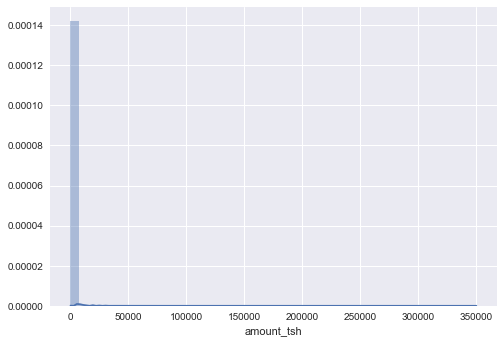

In [13]:
sns.distplot(data.amount_tsh)

plt.show()

In [14]:
#too many null values useless
data.drop('amount_tsh', axis = 1, inplace = True)

In [48]:
# Function retrieved and adapted from fastai library
def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','', fldname)
    df[targ_pre+'Month'] = getattr(fld.dt,'Month'.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1)
    return df
#add_datepart(x_test, 'date_recorded',x_test['date_recorded'].min())

In [46]:
#Misstype for years 2001, 2002, 2004?
copy = data
data.loc[data['date_recorded'].dt.year < 2010, 'date_recorded'] = data.loc[data['date_recorded'].dt.year < 2010, 'date_recorded'].apply(lambda x: x + np.timedelta64(10, 'Y'))
datar = data.date_recorded.apply(lambda x : int(str(x)[0:4]))
datar = pd.get_dummies(datar)
print(datar.sum())

2011    35909
2012     8090
2013    30210
2014       41
dtype: int64


In [49]:
data = add_datepart(data, 'date_recorded')
data.columns

Index(['id', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'date_recordedMonth', 'date_recordedElapsed'],
      dtype='object')

### Fixing geographical features

In [67]:
# Set 0 longitude to NaN
data.loc[data.longitude == 0, 'longitude'] = np.nan
data.longitude.isnull().sum()

2269

In [68]:
# Replace NaN with average longitude of the subvillage they belong
data.longitude.fillna(data.groupby(['subvillage'])['longitude'].transform('mean'), inplace=True)
data.longitude.isnull().sum()

1265

In [69]:
# average of ward (the smallest division after subvillage)
data.longitude.fillna(data.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
data.longitude.isnull().sum()

12

In [70]:
data.longitude.fillna(data.groupby(['lga'])['longitude'].transform('mean'), inplace=True)
data.longitude.isnull().sum()

0

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


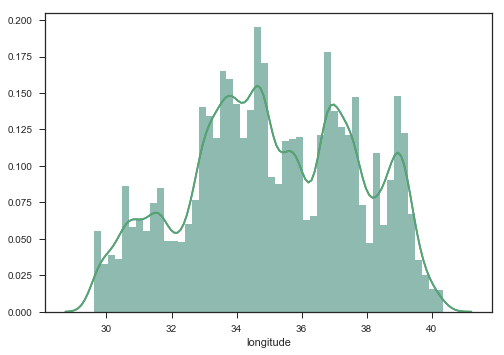

In [72]:
data.longitude = data.longitude.round(2)
sns.distplot(data.longitude)
plt.show()

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


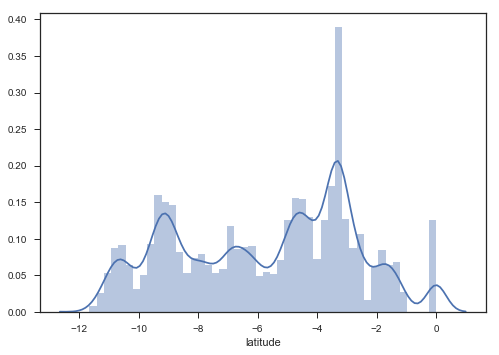

In [73]:
data.loc[data.latitude == 0, 'latitude'] = np.nan
data.latitude.fillna(data.groupby(['subvillage'])['latitude'].transform('mean'), inplace=True)
data.latitude.fillna(data.groupby(['ward'])['latitude'].transform('mean'), inplace=True)
data.latitude.fillna(data.groupby(['lga'])['latitude'].transform('mean'), inplace=True)
sns.distplot(data.latitude)
plt.show()

In [74]:
data.loc[data.gps_height == 0, 'gps_height'] = np.nan
data.gps_height.fillna(data.groupby(['subvillage'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.fillna(data.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.fillna(data.groupby(['lga'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.isnull().sum()

2

In [76]:
data.gps_height.fillna(data.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.isnull().sum()

0

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


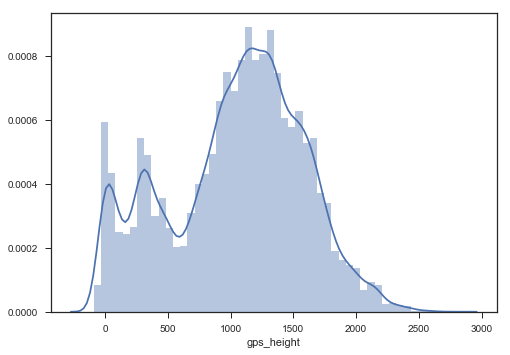

In [77]:
sns.distplot(data.gps_height)
plt.show()

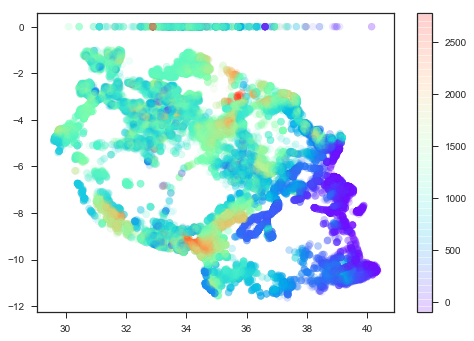

In [78]:
plt.scatter(data.longitude, data.latitude, alpha = .1, c = data.gps_height, cmap = 'rainbow')
plt.colorbar()
plt.show()

# EDA

In [19]:
cat_df = pd.DataFrame(columns=["Feature", "Cardinality","% Missings"])

total_cardinality = 0

i=0

for col in x_train.columns:
    if (x_train[col].dtype == np.object):
        cat_df.loc[i,"Feature"] = col
        cat_df.loc[i,"Cardinality"] = len(x_train[col].unique())
        total_cardinality += len(x_train[col].unique())
        pct_of_missing_values = float((len(x_train[col]) - x_train[col].count()) / len(x_train[col]))
        cat_df.loc[i,"% Missings"] = pct_of_missing_values*100
        i+=1

print("Total cardinality of categorical features:",total_cardinality)

cat_df

Total cardinality of categorical features: 65822


,Feature,Cardinality,% Missings
0,funder,1898,6.11953
1,installer,2146,6.1532
2,wpt_name,37400,0
3,basin,9,0
4,subvillage,19288,0.624579
5,region,21,0
6,lga,125,0
7,ward,2092,0
8,public_meeting,3,5.61279
9,recorded_by,1,0


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


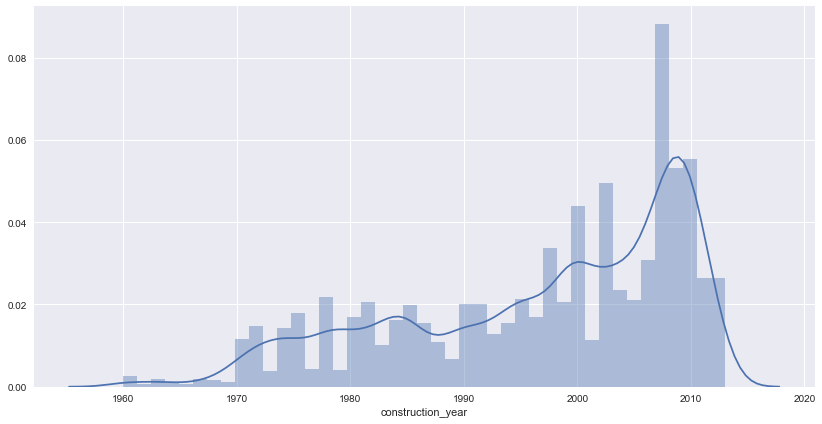

In [20]:
plt.figure(figsize=(14,7))
sns.distplot(data_viz['construction_year'][data_viz['construction_year']>0])
plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


<Figure size 1008x504 with 0 Axes>

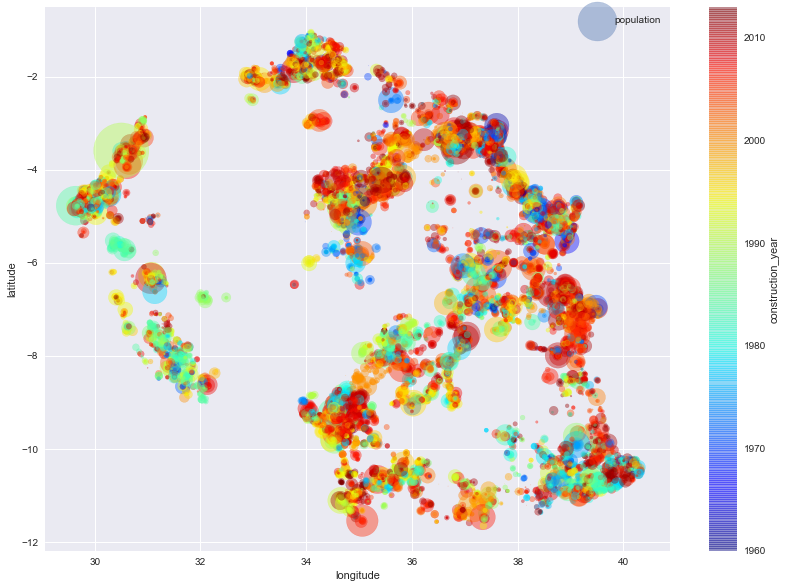

In [21]:
#Water pump geographical distribution with population proportional circles and year of pump color bar

plt.figure(figsize=(14,7))
data_viz[data_viz['longitude']>0][data_viz['latitude']<0][data_viz['construction_year']>0].plot\
    (kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data_viz["population"]/10, label="population", figsize=(14,10),
    c="construction_year", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

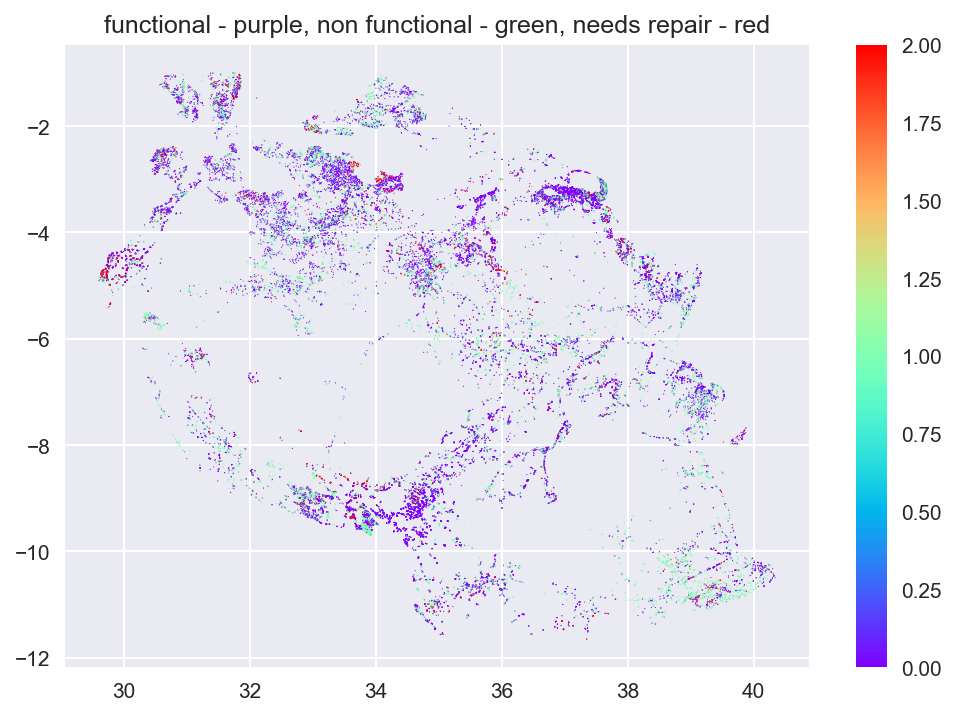

In [22]:
plt.figure(1,dpi=150)
x_geo = x_train.drop(x_train[x_train['longitude'] == 0].index)
y_geo = y_num.drop(x_train[x_train['longitude'] == 0].index)
plt.scatter(x_geo['longitude'], x_geo['latitude'], c = y_geo.iloc[:,1], cmap = 'rainbow', s = 0.05)
plt.title("functional - purple, non functional - green, needs repair - red")
plt.colorbar()
plt.show()

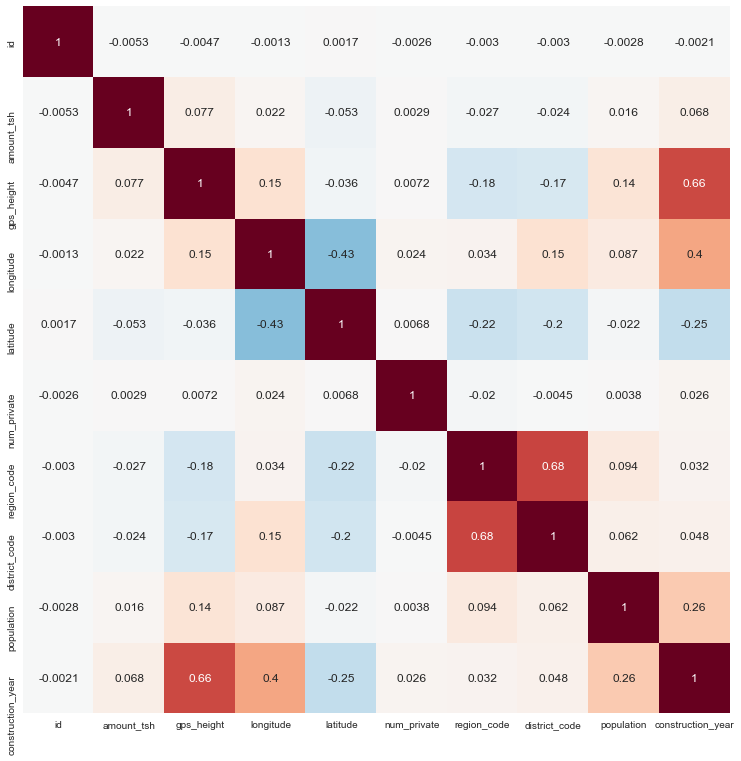

In [23]:
cor = data_viz.corr()
plt.figure(figsize=(14,13))
sns.heatmap(cor, square=True, annot=True, cbar=False)
plt.show()

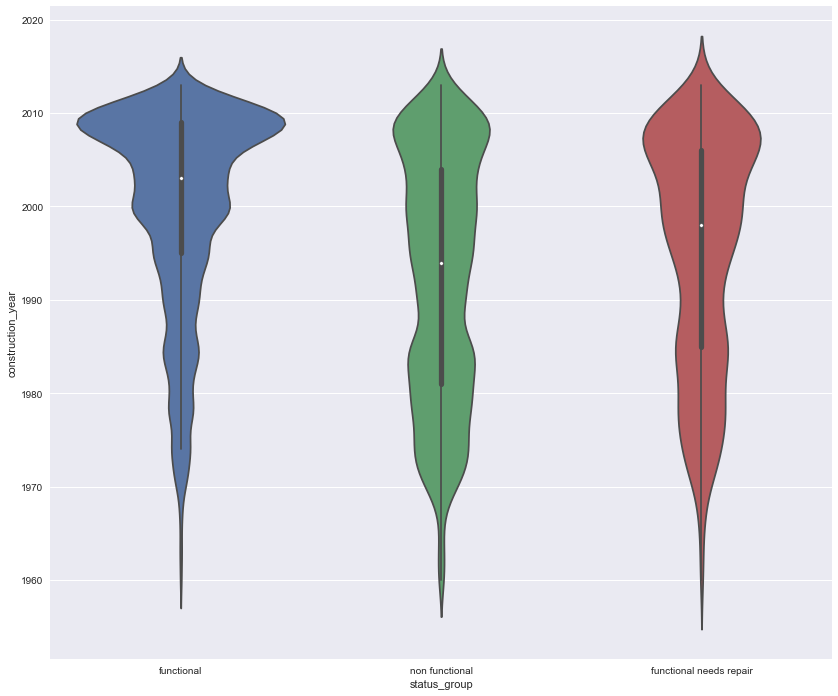

In [24]:
fig, ax = plt.subplots(figsize=(14,12));
ax = sns.violinplot(x='status_group', y="construction_year",\
                    data=data_viz[data_viz['construction_year']>0], split=True)
plt.show()

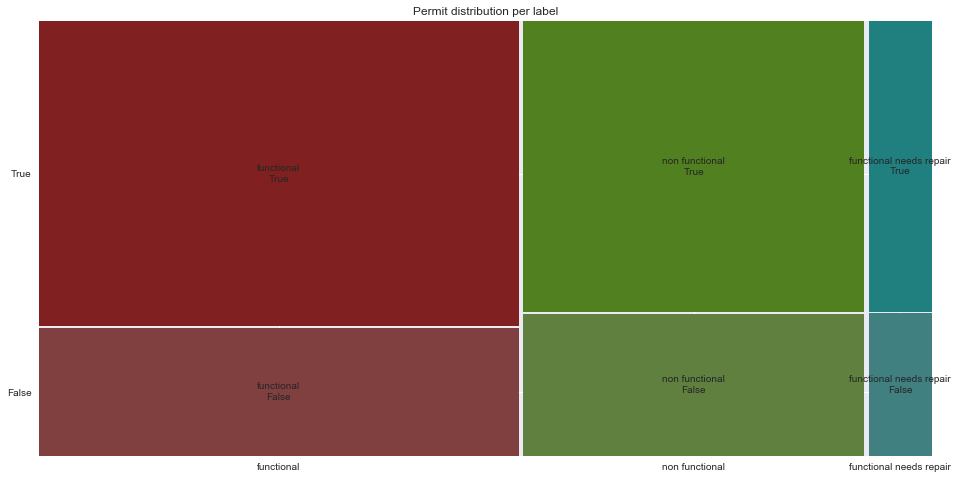

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
mosaic(data_viz, ['status_group', 'permit'], axes, title="Permit distribution per label")
plt.show()

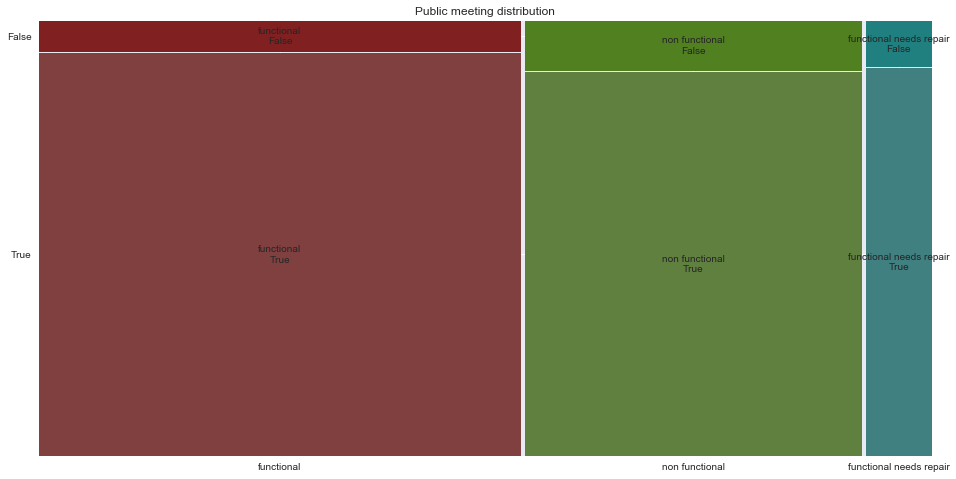

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
mosaic(data_viz, ['status_group', 'public_meeting'], axes, title="Public meeting distribution")
plt.show()

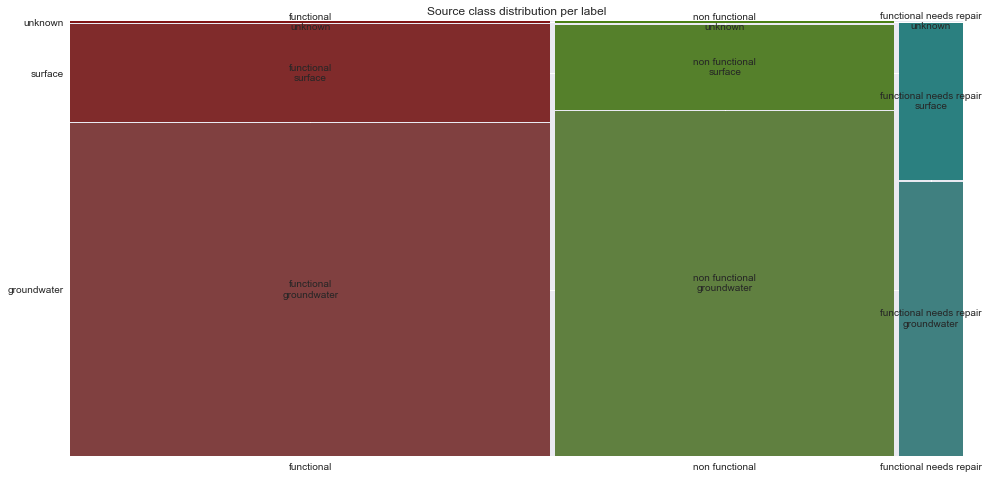

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
mosaic(data_viz, ['status_group', 'source_class'], axes, title="Source class distribution per label")
plt.show()

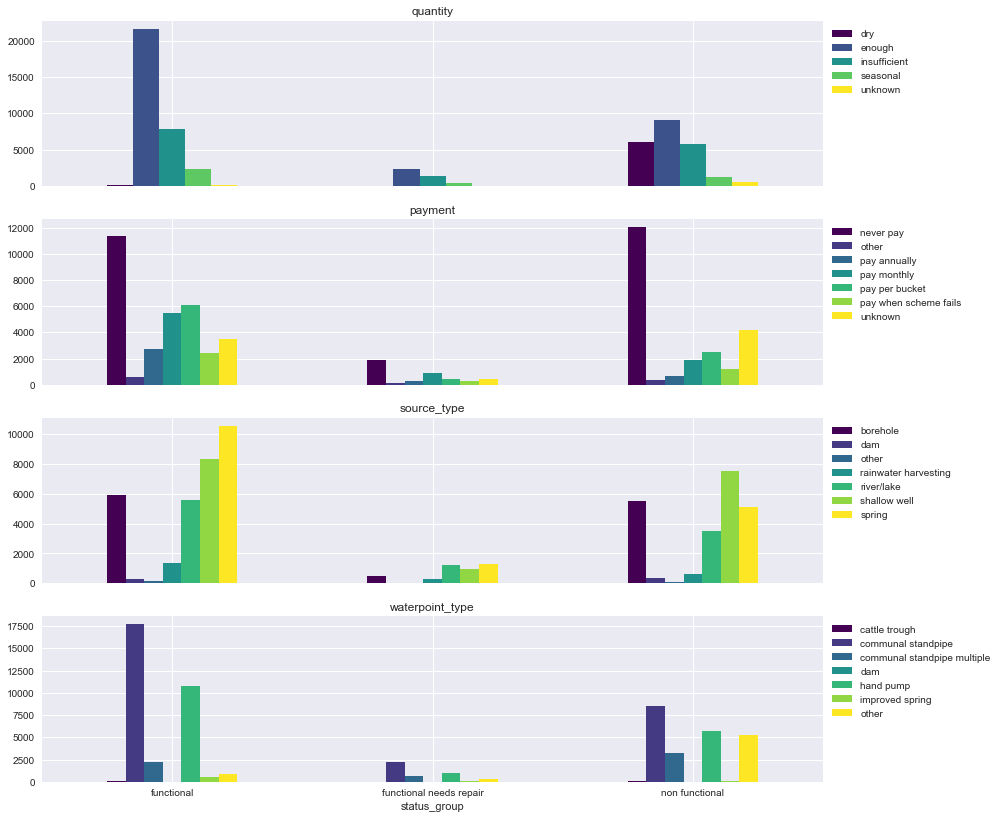

In [28]:
variables = ['quantity','payment','source_type','waterpoint_type']
label = 'status_group'

def plot_tables(data,label,variables):
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize = (14,14))
    for i,variable in enumerate(variables):
        ax = pd.pivot_table(data[[label,variable]], index = [label,variable], aggfunc = len)\
        .unstack(variable).plot(kind='bar', ax=axes[i], sharex=True, title=variable, rot=0, colormap='viridis')
        ax.legend(bbox_to_anchor=(1,1),loc="upper left")
    plt.show()
        
plot_tables(data_viz,label,variables)

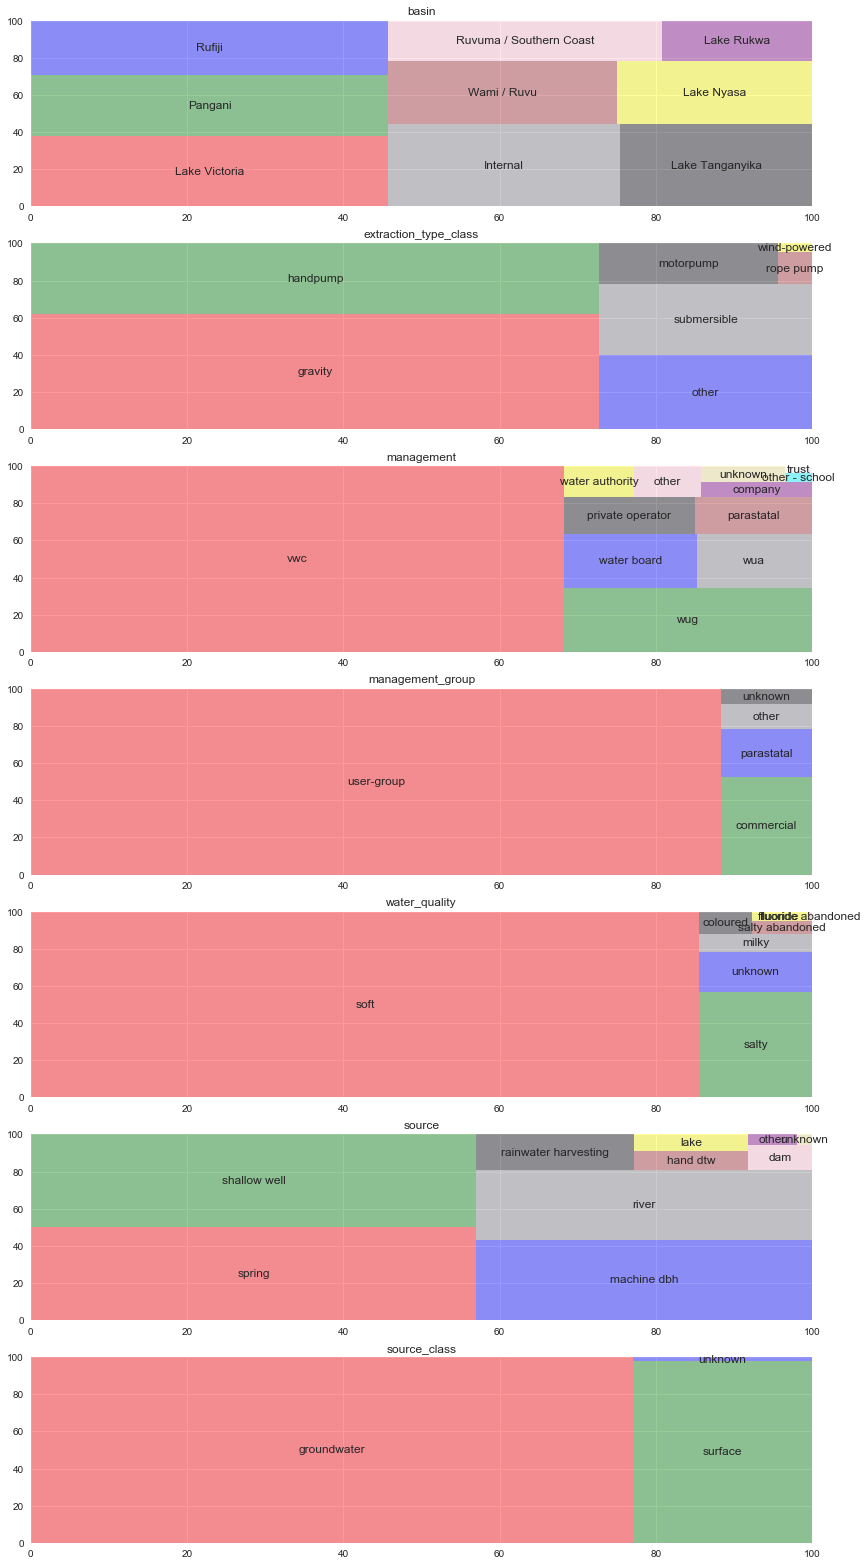

In [29]:
variables = ['basin','extraction_type_class','management','management_group',
             'water_quality','source','source_class']
colors = ["red","green","blue", "grey", "black", "brown", "yellow", "pink", "purple", "khaki", "cyan","white"]

def plot_proportions(data,variables):
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize = (14,len(variables)*4))
    for i,variable in enumerate(variables):
        ax = squarify.plot(sizes=data[variable].value_counts().tolist(), 
                      label=data[variable].value_counts().index.tolist(), color=colors, ax=axes[i], alpha=.4)
        ax.set_title(variable)
    plt.show()
        
plot_proportions(data_viz,variables)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


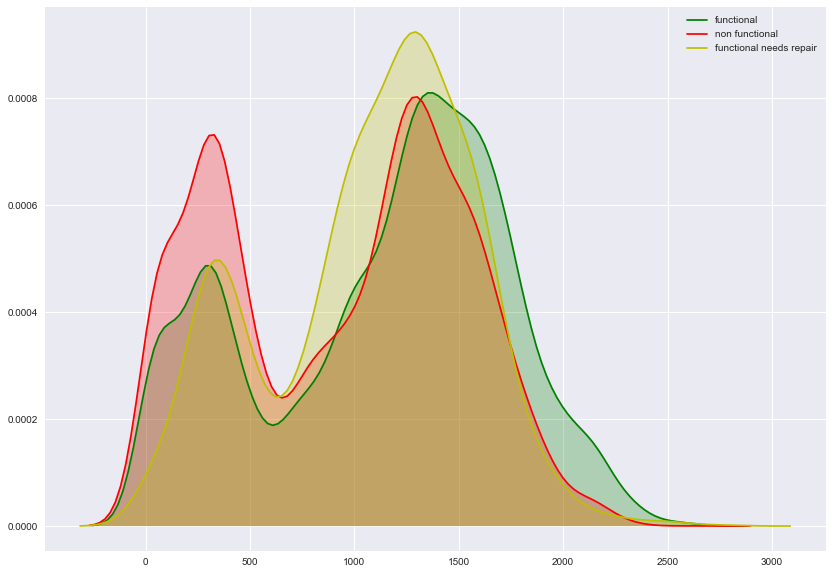

In [30]:
# Height distrinbution per label
plt.figure(figsize=(14,10))

p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'functional']
               [data_viz.gps_height > 0].gps_height, shade=True, color="g",label='functional')
p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'non functional']
               [data_viz.gps_height > 0].gps_height, shade=True, color="r",label='non functional')
p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'functional needs repair']
               [data_viz.gps_height > 0].gps_height, shade=True, color="y",label='functional needs repair')

plt.show()

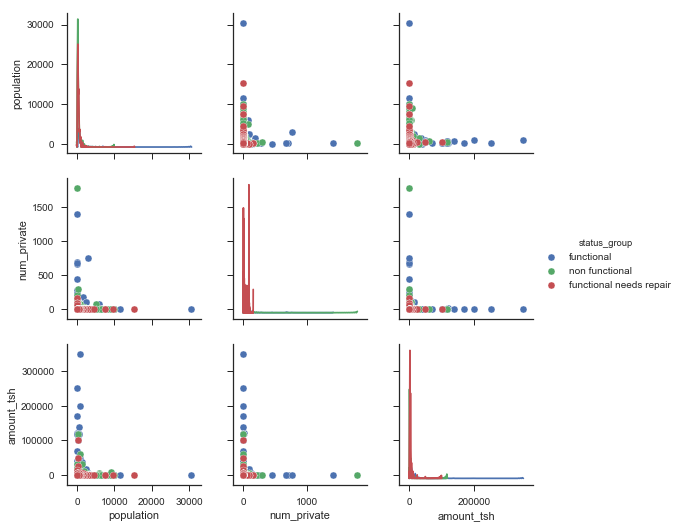

In [31]:
#Pair plot of the relevant numerical features against each other, differentiating by label value
sns.set(style="ticks")
sns.pairplot(data_viz[['population','num_private','amount_tsh','status_group']],
                    hue="status_group", diag_kind="kde")
plt.show()

# Data Preparation

In [32]:
# Drop recorded_by column (constant value)
x_train.drop(['recorded_by'], axis=1, inplace=True)
x_test.drop(['recorded_by'], axis=1, inplace=True)
# Drop values with high cardinality
x_train.drop(['funder', 'installer', 'lga', 'scheme_name', 'subvillage', 'ward', 'wpt_name'], axis=1, inplace=True)
x_test.drop(['funder', 'installer', 'lga', 'scheme_name', 'subvillage', 'ward', 'wpt_name'], axis=1, inplace=True)

In [33]:
# Function retrieved and adapted from fastai library
def add_datepart(df, fldname, mindate):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','', fldname)
    df[targ_pre+'Month'] = getattr(fld.dt,'Month'.lower())
    df[targ_pre+'Elapsed'] = (fld - mindate).dt.days
    df.drop(fldname, axis=1, inplace=True)
add_datepart(x_train, 'date_recorded', x_test['date_recorded'].min())
add_datepart(x_test, 'date_recorded',x_test['date_recorded'].min())

In [34]:
x_train['date_recordedElapsed'].min()

567

In [35]:
# Turn all data types into categorical data types
def train_cats(df):
     for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [36]:
train_cats(x_train)
train_cats(x_test)
x_train.isnull().sum().sort_index()/len(x_train)
# x_test.isnull().sum().sort_index()/len(x_test)

amount_tsh               0.000000
basin                    0.000000
construction_year        0.000000
date_recordedElapsed     0.000000
date_recordedMonth       0.000000
district_code            0.000000
extraction_type          0.000000
extraction_type_class    0.000000
extraction_type_group    0.000000
gps_height               0.000000
id                       0.000000
latitude                 0.000000
longitude                0.000000
management               0.000000
management_group         0.000000
num_private              0.000000
payment                  0.000000
payment_type             0.000000
permit                   0.051448
population               0.000000
public_meeting           0.056128
quality_group            0.000000
quantity                 0.000000
quantity_group           0.000000
region                   0.000000
region_code              0.000000
scheme_management        0.065269
source                   0.000000
source_class             0.000000
source_type   

In [37]:
x_train['permit'].fillna(x_train['permit'].mode()[0], inplace=True)
x_test['permit'].fillna(x_test['permit'].mode()[0], inplace=True)

x_train['public_meeting'].fillna(x_train['public_meeting'].mode()[0], inplace=True)
x_test['public_meeting'].fillna(x_test['public_meeting'].mode()[0], inplace=True)

x_train['scheme_management'].fillna(x_train['scheme_management'].mode()[0], inplace=True)
x_test['scheme_management'].fillna(x_test['scheme_management'].mode()[0], inplace=True)

In [38]:
x_train.isnull().sum().sort_index()/len(x_train)
# x_test.isnull().sum().sort_index()/len(x_test)

amount_tsh               0.0
basin                    0.0
construction_year        0.0
date_recordedElapsed     0.0
date_recordedMonth       0.0
district_code            0.0
extraction_type          0.0
extraction_type_class    0.0
extraction_type_group    0.0
gps_height               0.0
id                       0.0
latitude                 0.0
longitude                0.0
management               0.0
management_group         0.0
num_private              0.0
payment                  0.0
payment_type             0.0
permit                   0.0
population               0.0
public_meeting           0.0
quality_group            0.0
quantity                 0.0
quantity_group           0.0
region                   0.0
region_code              0.0
scheme_management        0.0
source                   0.0
source_class             0.0
source_type              0.0
water_quality            0.0
waterpoint_type          0.0
waterpoint_type_group    0.0
dtype: float64

In [39]:
notnumber = list(x_train.select_dtypes(exclude=[np.number]))
print(notnumber)
x_train.T

['basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


,0,1,2,3,4,5,6,7,8,9,...,59390,59391,59392,59393,59394,59395,59396,59397,59398,59399
id,69572,8776,34310,67743,19728,9944,19816,54551,53934,46144,...,13677,44885,40607,48348,11164,60739,27263,37057,31282,26348
amount_tsh,6000,0,25,0,0,20,0,0,0,0,...,0,0,0,0,500,10,4700,0,0,0
gps_height,1390,1399,686,263,0,0,0,0,0,0,...,1715,540,0,0,351,1210,1212,0,0,191
longitude,34.9381,34.6988,37.4607,38.4862,31.1308,39.1728,33.3624,32.6206,32.7111,30.627,...,31.3708,38.0441,33.0094,33.8669,37.6341,37.1698,35.25,34.0171,35.8613,38.104
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536,-4.76559,-3.76636,-4.2262,-5.14671,-1.25705,...,-8.25816,-4.27222,-8.52089,-4.28741,-6.12483,-3.25385,-9.07063,-8.75043,-6.37857,-6.74746
num_private,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
basin,Lake Nyasa,Lake Victoria,Pangani,Ruvuma / Southern Coast,Lake Victoria,Pangani,Internal,Lake Tanganyika,Lake Tanganyika,Lake Victoria,...,Lake Tanganyika,Pangani,Lake Rukwa,Internal,Wami / Ruvu,Pangani,Rufiji,Rufiji,Rufiji,Wami / Ruvu
region,Iringa,Mara,Manyara,Mtwara,Kagera,Tanga,Shinyanga,Shinyanga,Tabora,Kagera,...,Rukwa,Kilimanjaro,Mbeya,Tabora,Morogoro,Kilimanjaro,Iringa,Mbeya,Dodoma,Morogoro
region_code,11,20,21,90,18,4,17,17,14,18,...,15,3,12,14,5,3,11,12,1,5
district_code,5,2,4,63,1,8,3,3,6,1,...,2,3,1,2,6,5,4,7,4,2


In [40]:
x_train = pd.get_dummies(x_train, notnumber)
x_test = pd.get_dummies(x_test, notnumber)

In [41]:
print(x_train.shape, x_test.shape)

(59400, 184) (14850, 182)


In [42]:
x_train.columns.difference(x_test.columns)

Index(['extraction_type_other - mkulima/shinyanga', 'scheme_management_None'], dtype='object')

In [43]:
x_train.drop(['extraction_type_other - mkulima/shinyanga', 'scheme_management_None'], axis = 1, inplace=True)

# Training

In [44]:
#x_train.drop('id', axis = 1, inplace = True)
X = preprocessing.StandardScaler().fit(x_train).transform(x_train.astype(float))
labels.drop('id', axis = 1, inplace = True)
trainx, validx, trainy, validy = train_test_split(X, labels, test_size = x_test.shape[0])
print('Training set: ', trainx.shape, trainy.shape)
print('Testing set: ', validx.shape, validy.shape)

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Training set:  (44550, 182) (44550, 3)
Testing set:  (14850, 182) (14850, 3)


In [45]:
rfc_params = {'n_estimators':[2,5,10,20,50,75,150],
              'criterion':['gini', 'entropy'],
              'max_depth':[2,5,10,20,50,None],
              'min_samples_split':[2,5,10,20]}


grid_rfc = GridSearchCV(RandomForestClassifier(), 
                        rfc_params, 
                        cv=5, 
                        scoring='accuracy').fit(trainx, trainy)

KeyboardInterrupt: 

In [ ]:
pred = grid_rfc.predict(validx)
print('Train set Accuracy: ', accuracy_score(trainy, grid_rfc.predict(trainx)))
print('Test set Accuracy: ', accuracy_score(validy, pred))

In [ ]:
print(grid_rfc.best_estimator_)
print(grid_rfc.best_score_)